## Imports

In [1]:
import os
import numpy as np
from time import time

from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter

from matplotlib import pylab as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

In [2]:
import inpaint

## Setup

In [13]:
# device_ids = [2, 3]
device_ids = [2]

class config:
    title = 'test'
#     title = 'InpaintNet[test, +fat strokes, warm start from 50.pth prod]'
    
    device = torch.device('cuda:{}'.format(device_ids[0])) if torch.cuda.is_available() else torch.device('cpu')
    device_ids = device_ids  # used for multi-gpu
    
#     train_dataset_path = '../celebA-HQ-all/train'
#     val_dataset_path = '../celebA-HQ-all/val'
    train_dataset_path = '../celebA-HQ-medium/train'
    val_dataset_path = '../celebA-HQ-medium/val'
    masks_dir = '../quick_draw/'
    
    in_channels = 3
    out_channels = 3
    
    train_batch_size = 8 * len(device_ids)
    val_batch_size = 8 * len(device_ids)
    
    lr = 0.0001
    n_epochs = 1000000
    
    min_stroke_width = 5
    max_stroke_width = 15
    
    fat_stroke_width = 40
    fat_stroke_prob = 0.2
    
#     state_dict_path = 'checkpoints/InpaintNet[no sigmoid all]@12.05.2018 11:49:52/50.pth'
    state_dict_path = None
    
    val_n_images_to_draw = 20
    
    checkpoints_root_path = './checkpoints'
    tensorboard_path = './tensorboard'
    
    n_workers = 4
    
    # loss coefficients
    valid_coef = 1
    hole_coef = 6
    perceptual_coef = 0.05
    style_coef = 120
    tv_coef = 0.1

## Data

In [ ]:
train_dataloader = inpaint.make_dataloader(config.train_dataset_path, config.masks_dir,
                                           val=False,
                                           min_stroke_width=config.min_stroke_width, max_stroke_width=config.max_stroke_width,
                                           fat_stroke_width=config.fat_stroke_width, fat_stroke_prob=config.fat_stroke_prob,
                                           batch_size=config.train_batch_size,
                                           shuffle=True,
                                           num_workers=config.n_workers)

val_dataloader = inpaint.make_dataloader(config.val_dataset_path, config.masks_dir,
                                         val=True,
                                         min_stroke_width=config.min_stroke_width, max_stroke_width=config.max_stroke_width,
                                         fat_stroke_width=config.fat_stroke_width, fat_stroke_prob=config.fat_stroke_prob,
                                         batch_size=config.val_batch_size,
                                         shuffle=False,
                                         num_workers=config.n_workers)

## Load model and associated stuff

Model:

In [5]:
model = inpaint.module.InpaintNet(config.in_channels, config.out_channels).to(config.device)

if len(config.device_ids) > 1:
    model = nn.DataParallel(model, device_ids=config.device_ids)
    
if config.state_dict_path is not None:
    model.load_state_dict(torch.load(config.state_dict_path))

Optimizer:

In [6]:
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.lr)

Losses:

In [7]:
inpaint_criterion = inpaint.module.InpaintLoss(
    valid_coef=config.valid_coef,
    hole_coef=config.hole_coef,
    perceptual_coef=config.perceptual_coef,
    style_coef=config.style_coef,
    tv_coef=config.tv_coef,
).to(config.device)

if len(config.device_ids) > 1:
    inpaint_criterion = nn.DataParallel(inpaint_criterion, device_ids=config.device_ids)

l1_criterion = nn.L1Loss().to(config.device)

Tensorboard writer:

In [8]:
experiment_name = '{}@{}'.format(config.title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
print(experiment_name)

writer = SummaryWriter(os.path.join(config.tensorboard_path, experiment_name))

InpaintNet[test, +fat strokes, warm start from 50.pth prod]@28.05.2018-14:57:27


Checkpoints:

In [9]:
checkpoints_dir = os.path.join(config.checkpoints_root_path, experiment_name)
if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)
    
print(checkpoints_dir)

./checkpoints/InpaintNet[test, +fat strokes, warm start from 50.pth prod]@28.05.2018-14:57:27


## Train loop

In [10]:
def expand_mask(mask_batch, n_channels):
    return torch.cat([mask_batch.unsqueeze(1)] * n_channels, dim=1)

def preprocess_batch(batch):
    image_batch, mask_batch = batch
    image_batch, mask_batch = image_batch.type(torch.float32), mask_batch.type(torch.float32)
    
    mask_batch = expand_mask(mask_batch, config.in_channels)
    
    image_masked_batch = image_batch * mask_batch
    
    return image_batch, image_masked_batch, mask_batch

Check it:

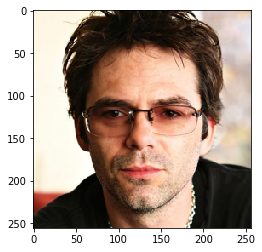

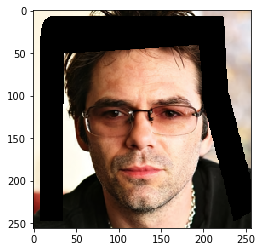

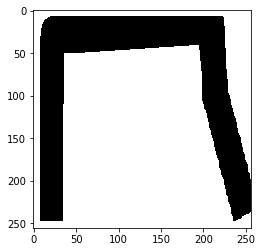

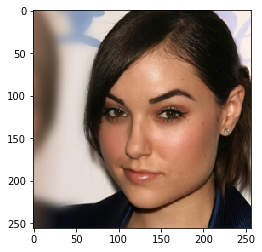

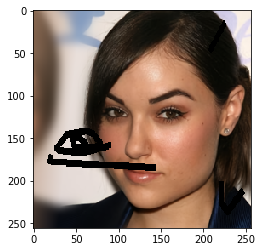

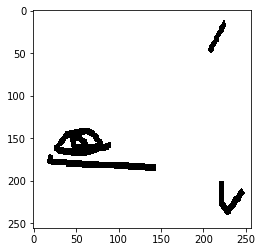

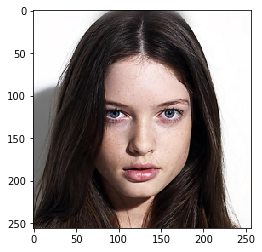

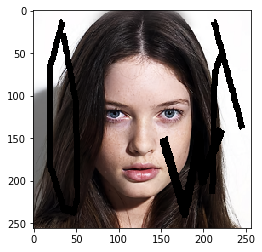

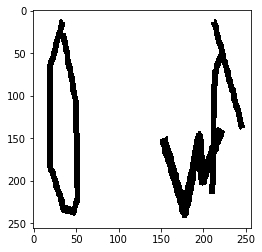

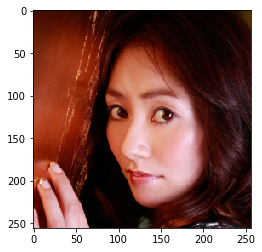

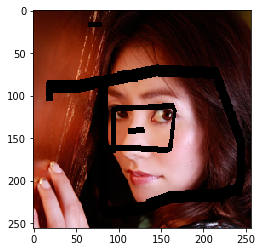

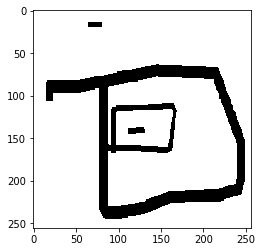

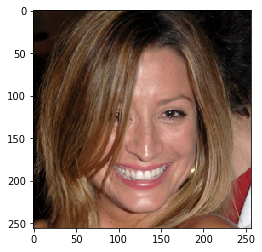

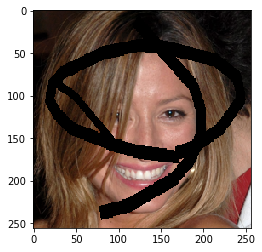

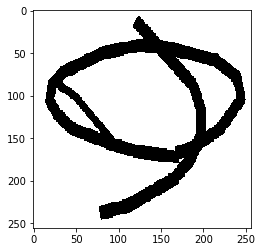

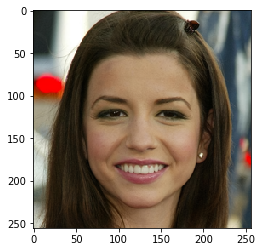

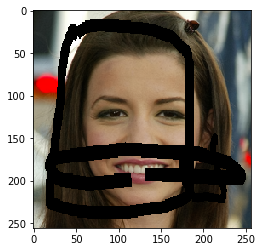

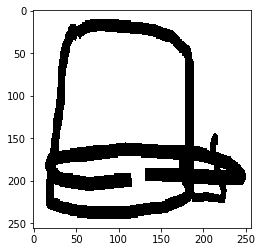

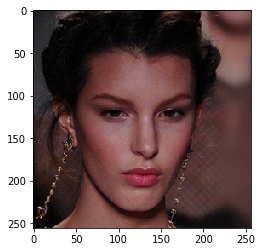

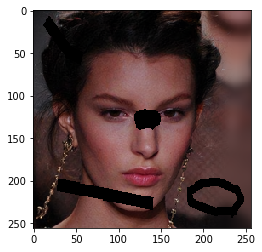

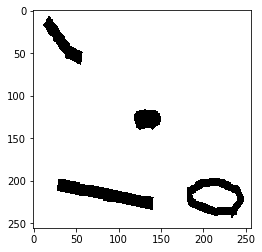

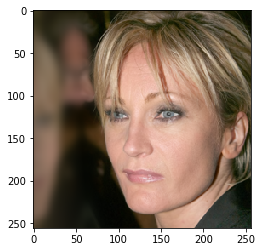

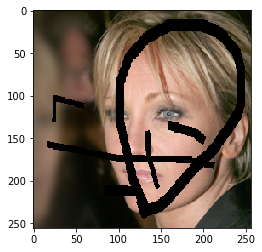

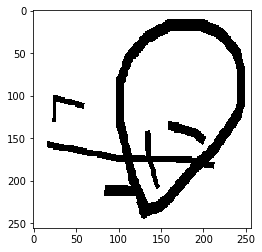

In [11]:
i = 0
for batch in tqdm(train_dataloader):
    image_batch, image_masked_batch, mask_batch = preprocess_batch(batch)
    
    for image, image_masked, mask in zip(image_batch, image_masked_batch, mask_batch):
        plt.imshow(image.numpy().transpose((1, 2, 0)))
        plt.show()
        
        plt.imshow(image_masked.numpy().transpose((1, 2, 0)))
        plt.show()
        
        plt.imshow(mask.numpy().transpose((1, 2, 0)))
        plt.show()

    i += 1
    if i >= 1: break 

In [ ]:
times = {
    'train_inference': [],
    'val_inference': [],
    'train_loss': [],
    'val_loss': [],
    'backprop': [],
    'train_all': [],
    'val_all': [],
    'train_batch': [],
    'epoch': []
}

i = 0
for epoch in range(config.n_epochs):
    epoch_start = time()
    
    print('Epoch: {}'.format(epoch))
    
    # dump model's parameters tensorboard
    for name, param in model.named_parameters():
        writer.add_histogram(name, param.clone().to('cpu').data.numpy(), epoch)

    # Train
    model.train()
    train_inpaint_loss = train_l1_loss = train_batches = 0
    for batch in tqdm(train_dataloader):
        train_all_start = time()
        
        train_batch_start = time()
        image_batch, image_masked_batch, mask_batch = preprocess_batch(batch)
        times['train_batch'].append(time() - train_batch_start)
        
        # to device
        image_batch = image_batch.to(config.device)
        image_masked_batch = image_masked_batch.to(config.device)
        mask_batch = mask_batch.to(config.device)
        
        # inference and backprop
        train_inference_start = time()
        image_pred_batch, _ = model(image_masked_batch, mask_batch)
        times['train_inference'].append(time() - train_inference_start)
        
        train_loss_start = time()
        inpaint_loss = inpaint_criterion(image_pred_batch, mask_batch, image_batch)
        inpaint_loss = torch.mean(inpaint_loss)  # it returns multiple values (done for multi-gpu)
        times['train_loss'].append(time() - train_loss_start)
        
        backprop_start = time()
        inpaint_loss.backward()
        opt.step()
        opt.zero_grad()
        times['backprop'].append(time() - backprop_start)
                
        # measure L1 loss
        l1_loss = l1_criterion(image_pred_batch, image_batch)
        
        # collect metrics
        n_iters = epoch * len(train_dataloader) + train_batches
        writer.add_scalar('train/inpaint_loss', inpaint_loss.item(), n_iters)
        writer.add_scalar('train/l1_loss', l1_loss.item(), n_iters)
        
        train_inpaint_loss += inpaint_loss.item()
        train_l1_loss += l1_loss.item()
        train_batches += 1
        
        times['train_all'].append(time() - train_all_start)
        
    print('Train inpaint_loss:\t{:.5}, l1_loss:\t{:.5}'.format(
        train_inpaint_loss / train_batches, train_l1_loss / train_batches
    ))
    
    # Validation
    model.eval()
    val_inpaint_loss = val_l1_loss = val_batches =  0
    n_images_drawn = 0
    for batch in tqdm(val_dataloader):
        image_batch, image_masked_batch, mask_batch = preprocess_batch(batch)
        
        # to device
        with torch.no_grad():
            image_batch = image_batch.to(config.device)
            image_masked_batch = image_masked_batch.to(config.device)
            mask_batch = mask_batch.to(config.device)
        
        # inference
        image_pred_batch, _ = model(image_masked_batch, mask_batch)
        inpaint_loss = inpaint_criterion(image_pred_batch, mask_batch, image_batch)
        inpaint_loss = torch.mean(inpaint_loss)
        
        # measure L1 loss
        l1_loss = l1_criterion(image_pred_batch, image_batch)
        
        # collect metrics
        n_iters = epoch * len(val_dataloader) + val_batches
        if n_images_drawn < config.val_n_images_to_draw:
            writer.add_image('val/image_pred_{}'.format(n_images_drawn), torch.clamp(image_pred_batch[0], 0, 1), epoch)
            writer.add_image('val/image_masked_{}'.format(n_images_drawn), torch.clamp(image_masked_batch[0], 0, 1), epoch)
            writer.add_image('val/mask_{}'.format(n_images_drawn), torch.clamp(mask_batch[0], 0, 1), epoch)
            
        n_images_drawn += 1
        
        val_inpaint_loss += inpaint_loss.item()
        val_l1_loss += l1_loss.item()
        val_batches += 1
        
    writer.add_scalar('val/inpaint_loss', val_inpaint_loss / val_batches, epoch)
    writer.add_scalar('val/l1_loss', val_l1_loss / val_batches, epoch)
    
    print('Val inpaint_loss:\t{:.5}, l1_loss:\t{:.5}'.format(
        val_inpaint_loss / val_batches, val_l1_loss / val_batches
    ))
    print()

    torch.save(model.state_dict(), os.path.join(checkpoints_dir, '{}.pth'.format(epoch)))
    
    times['epoch'].append(time() - epoch_start)

Epoch: 0


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Train inpaint_loss:	0.80711, l1_loss:	0.012139



Val inpaint_loss:	0.8232, l1_loss:	0.011817

Epoch: 1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Train inpaint_loss:	0.7937, l1_loss:	0.012076


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Train inpaint_loss:	0.79494, l1_loss:	0.012215



Val inpaint_loss:	0.81206, l1_loss:	0.012017

Epoch: 3



Train inpaint_loss:	0.78779, l1_loss:	0.012126


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Train inpaint_loss:	0.77766, l1_loss:	0.012013



Val inpaint_loss:	0.80395, l1_loss:	0.011877

Epoch: 6


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Train inpaint_loss:	0.77544, l1_loss:	0.012015



Val inpaint_loss:	0.80512, l1_loss:	0.012194

Epoch: 7


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
for k, v in times.items():
    print(k, np.mean(v) if len(v) > 0 else None)

---